# Introduction to Automation with LangChain, Generative AI, and Python
**4.1: Image Generation**
* Instructor: [Jeff Heaton](https://youtube.com/@HeatonResearch), WUSTL Center for Analytics and Business Insight (CABI), [Washington University in St. Louis](https://olin.wustl.edu/faculty-and-research/research-centers/center-for-analytics-and-business-insight/index.php)
* For more information visit the [class website](https://github.com/jeffheaton/cabi_genai_automation).

In [4]:
import base64
import io
import json
import os
import sys

# External dependencies
import boto3
from PIL import Image
import botocore

boto3_bedrock = boto3.client('bedrock-runtime')

## Text to Image

In [5]:
prompt = "a beautiful mountain landscape"
negative_prompts = [
    "poorly rendered",
    "poor background details",
    "poorly drawn mountains",
    "disfigured mountain features",
]
style_preset = "photographic"  # (e.g. photographic, digital-art, cinematic, ...)
clip_guidance_preset = "FAST_GREEN" # (e.g. FAST_BLUE FAST_GREEN NONE SIMPLE SLOW SLOWER SLOWEST)
sampler = "K_DPMPP_2S_ANCESTRAL" # (e.g. DDIM, DDPM, K_DPMPP_SDE, K_DPMPP_2M, K_DPMPP_2S_ANCESTRAL, K_DPM_2, K_DPM_2_ANCESTRAL, K_EULER, K_EULER_ANCESTRAL, K_HEUN, K_LMS)
width = 768

In [6]:
request = json.dumps({
    "text_prompts": (
        [{"text": prompt, "weight": 1.0}]
        + [{"text": negprompt, "weight": -1.0} for negprompt in negative_prompts]
    ),
    "cfg_scale": 5,
    "seed": 42,
    "steps": 60,
    "style_preset": style_preset,
    "clip_guidance_preset": clip_guidance_preset,
    "sampler": sampler,
    "width": width,
})
modelId = "stability.stable-diffusion-xl-v1"

response = boto3_bedrock.invoke_model(body=request, modelId=modelId)
response_body = json.loads(response.get("body").read())

print(response_body["result"])
base_64_img_str = response_body["artifacts"][0].get("base64")
print(f"{base_64_img_str[0:80]}...")

success
iVBORw0KGgoAAAANSUhEUgAAAwAAAAQACAIAAADZRKlXAAAEImVYSWZNTQAqAAAACAAGAQAABAAAAAEA...


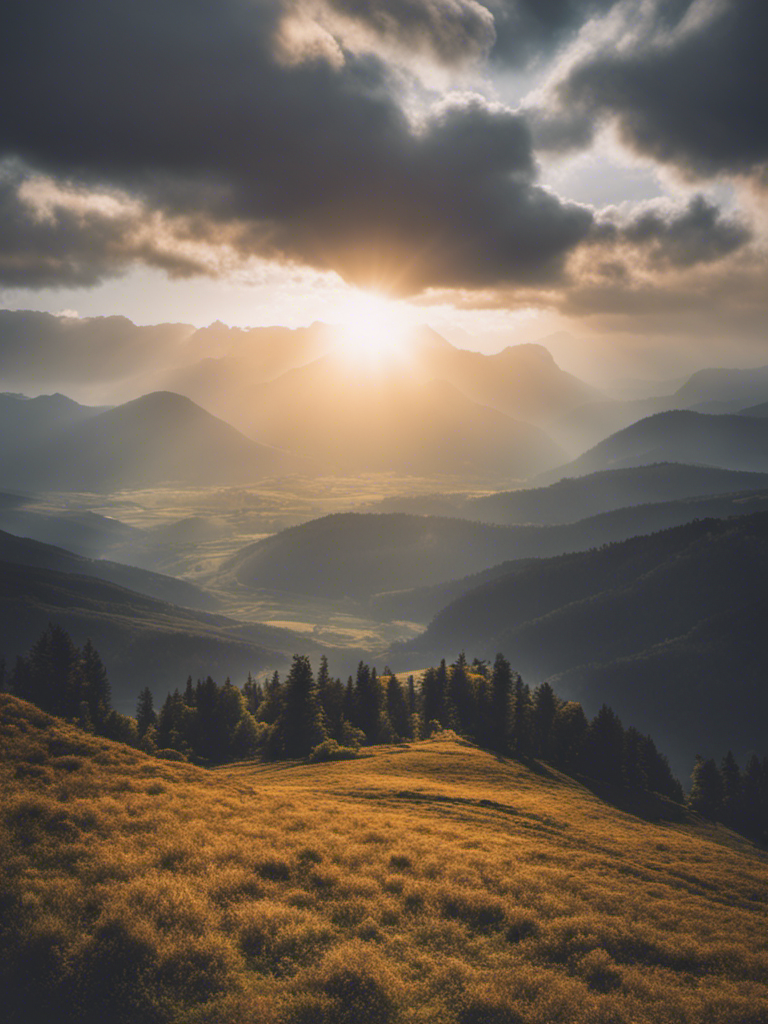

In [7]:
os.makedirs("data", exist_ok=True)
image_1 = Image.open(io.BytesIO(base64.decodebytes(bytes(base_64_img_str, "utf-8"))))
image_1.save("data/image_1.png")
image_1

## Image to Image

In [9]:
def image_to_base64(img) -> str:
    """Convert a PIL Image or local image file path to a base64 string for Amazon Bedrock"""
    if isinstance(img, str):
        if os.path.isfile(img):
            print(f"Reading image from file: {img}")
            with open(img, "rb") as f:
                return base64.b64encode(f.read()).decode("utf-8")
        else:
            raise FileNotFoundError(f"File {img} does not exist")
    elif isinstance(img, Image.Image):
        print("Converting PIL Image to base64 string")
        buffer = io.BytesIO()
        img.save(buffer, format="PNG")
        return base64.b64encode(buffer.getvalue()).decode("utf-8")
    else:
        raise ValueError(f"Expected str (filename) or PIL Image. Got {type(img)}")


init_image_b64 = image_to_base64(image_1)
print(init_image_b64[:80] + "...")

Converting PIL Image to base64 string
iVBORw0KGgoAAAANSUhEUgAAAwAAAAQACAIAAADZRKlXAAEAAElEQVR4nHz925IkR5IsCDKzqJlHJBK3...


In [10]:
change_prompt = "add denser number of trees, extend lake"

request = json.dumps({
    "text_prompts": (
        [{"text": change_prompt, "weight": 1.0}]
        + [{"text": negprompt, "weight": -1.0} for negprompt in negative_prompts]
    ),
    "cfg_scale": 10,
    "init_image": init_image_b64,
    "seed": 321,
    "start_schedule": 0.6,
    "steps": 50,
    "style_preset": style_preset,
    "clip_guidance_preset": clip_guidance_preset,
    "sampler": sampler,
})
modelId = "stability.stable-diffusion-xl-v1"

response = boto3_bedrock.invoke_model(body=request, modelId=modelId)
response_body = json.loads(response.get("body").read())

print(response_body["result"])
image_2_b64_str = response_body["artifacts"][0].get("base64")
print(f"{image_2_b64_str[0:80]}...")

success
iVBORw0KGgoAAAANSUhEUgAAAwAAAAQACAIAAADZRKlXAAHkxGVYSWZNTQAqAAAACAAGAQAABAAAAAEA...


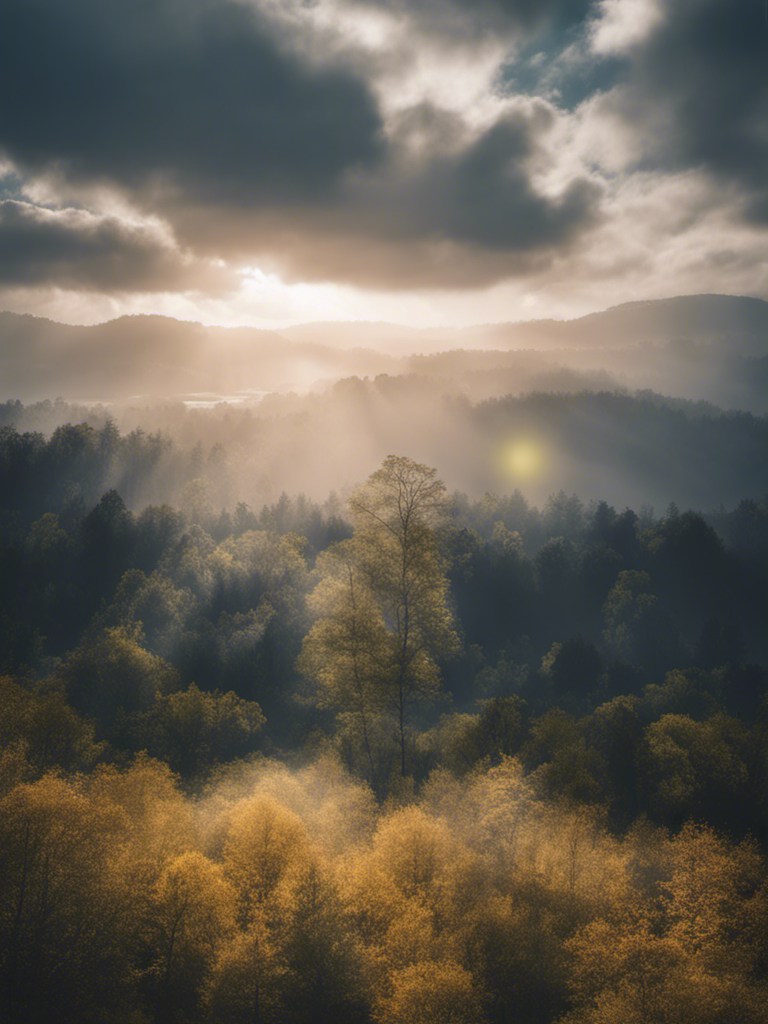

In [11]:
image_2 = Image.open(io.BytesIO(base64.decodebytes(bytes(image_2_b64_str, "utf-8"))))
image_2.save("data/image_2.png")
image_2

## Inpainting

In [12]:
from PIL import ImageOps

def inpaint_mask(img, box):
    """Generates a segmentation mask for inpainting"""
    img_size = img.size
    assert len(box) == 4  # (left, top, right, bottom)
    assert box[0] < box[2]
    assert box[1] < box[3]
    return ImageOps.expand(
        Image.new(
            mode = "RGB",
            size = (
                box[2] - box[0],
                box[3] - box[1]
            ),
            color = 'black'
        ),
        border=(
            box[0],
            box[1],
            img_size[0] - box[2],
            img_size[1] - box[3]
        ),
        fill='white'
    )

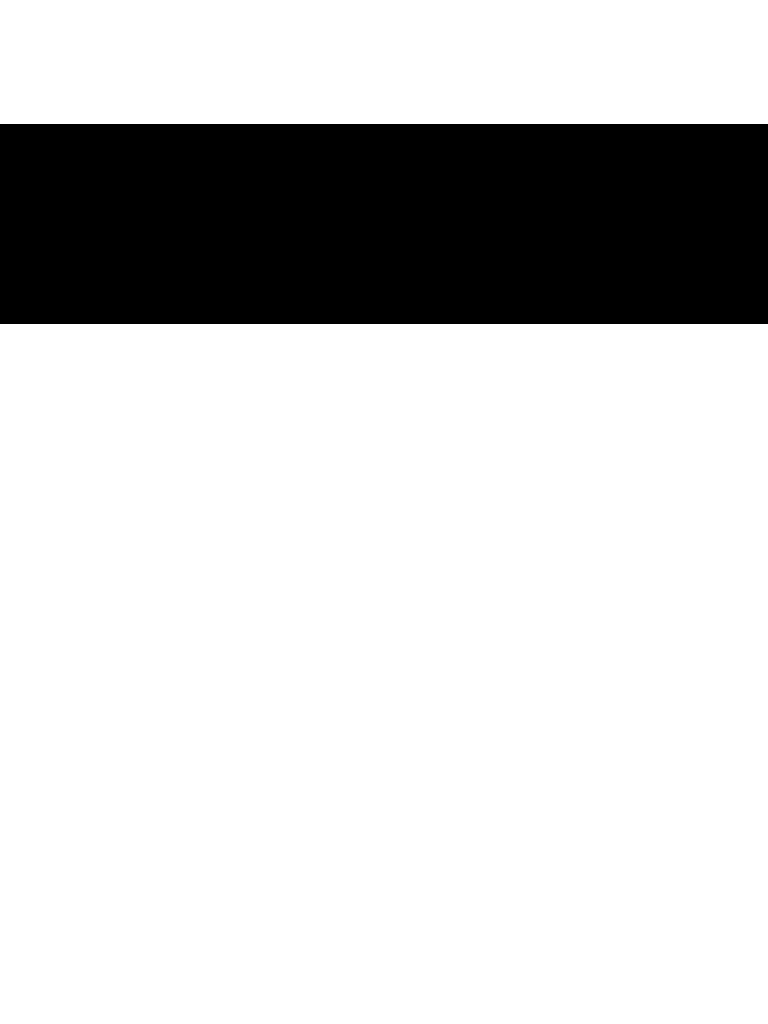

In [13]:
img2_size = image_2.size
box = (
        (0),
        (img2_size[1] - 900) ,
        (img2_size[0]),
        img2_size[1] - 700
    )

# Mask
mask = inpaint_mask(
    image_2,
    box
)

# Debug
mask

In [14]:
inpaint_prompt = "add a helicopter"

request = json.dumps({
    "text_prompts":[{"text": inpaint_prompt}],
    "init_image": image_to_base64(image_2),
    "mask_source": "MASK_IMAGE_BLACK",
    "mask_image": image_to_base64(mask),
    "cfg_scale": 10,
    "seed": 32123,
    "style_preset": style_preset,
})
modelId = "stability.stable-diffusion-xl-v1"

response = boto3_bedrock.invoke_model(body=request, modelId=modelId)
response_body = json.loads(response.get("body").read())

print(response_body["result"])
image_3_b64_str = response_body["artifacts"][0].get("base64")
print(f"{image_2_b64_str[0:80]}...")

Converting PIL Image to base64 string
Converting PIL Image to base64 string
success
iVBORw0KGgoAAAANSUhEUgAAAwAAAAQACAIAAADZRKlXAAHkxGVYSWZNTQAqAAAACAAGAQAABAAAAAEA...


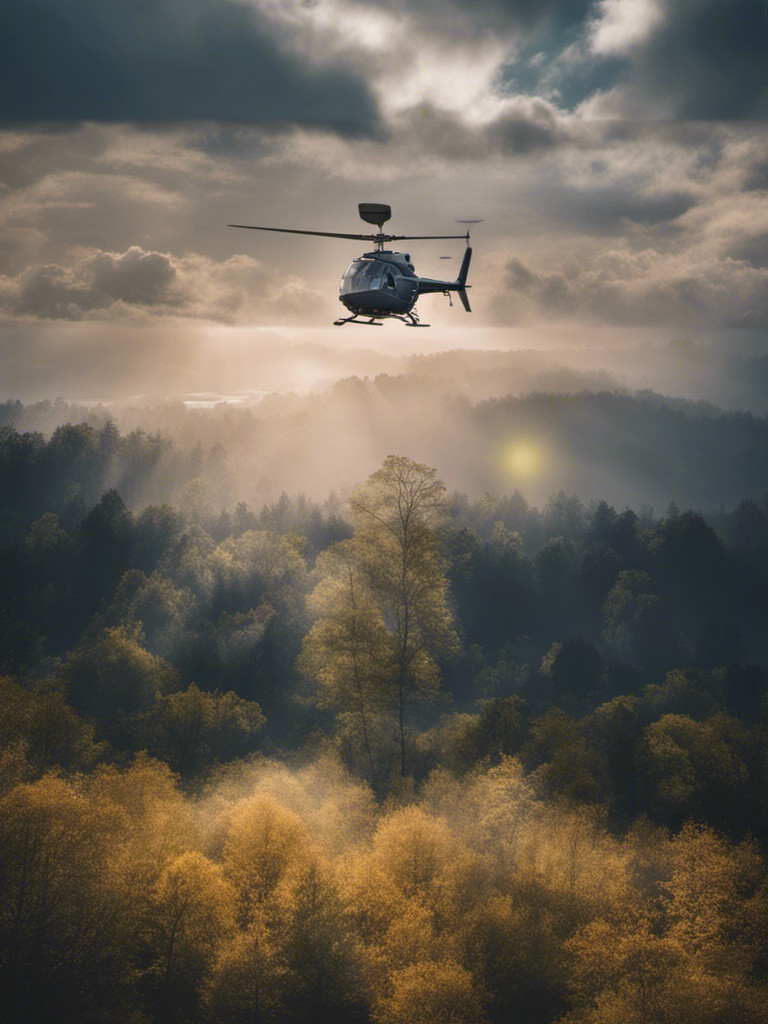

In [15]:
os.makedirs("data", exist_ok=True)
inpaint = Image.open(io.BytesIO(base64.decodebytes(bytes(image_3_b64_str, "utf-8"))))
inpaint.save("data/inpaint.png")
inpaint